# Setup

In [1]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# Load data

data_input = pd.read_csv("data.csv").set_index('id')
test_input = pd.read_csv("test.csv")
train_input = pd.read_csv("train.csv")
val_input = pd.read_csv("val.csv")

# View loaded data

In [3]:
headers = data_input.columns.values
header_text = ", ".join(["".join(x) for x in sorted(headers)])
print("Features are", header_text)
print("Feature num:", data_input.shape[1])
print("Data num:", data_input.shape[0])
print("Train num:", train_input.shape[0])
print("CV num:", val_input.shape[0])
print("Test num:", test_input.shape[0])

assert(test_input.shape[0] + val_input.shape[0] + train_input.shape[0] == data_input.shape[0])

Features are accommodates, amenities, bathrooms, bed_type, bedrooms, beds, first_review, host_identity_verified, host_is_superhost, host_listings_count, host_response_rate, host_response_time, host_since, is_location_exact, last_review, latitude, longitude, number_of_reviews, number_of_reviews_ltm, price, property_type, review_scores_accuracy, review_scores_checkin, review_scores_cleanliness, review_scores_communication, review_scores_location, review_scores_rating, review_scores_value, room_type, square_feet, zipcode
Feature num: 31
Data num: 10152
Train num: 6152
CV num: 1949
Test num: 2051


# Fix Data

In [4]:
# Do simple maps from string features to numeric values

# Numeric strings
data_input.loc[data_input.index[517], 'zipcode'] = "78702"
data_input['zipcode'] = pd.to_numeric(data_input['zipcode'])
data_input['host_response_rate'] = pd.to_numeric(data_input['host_response_rate'].str[:-1])

# Booleans
data_input['is_location_exact'] = pd.to_numeric([1 if x == "t" else 0 if x == "f" else float('NaN') for x in data_input['is_location_exact'].values])
data_input['host_is_superhost'] = pd.to_numeric([1 if x == "t" else 0 if x == "f" else float('NaN') for x in data_input['host_is_superhost'].values])
data_input['host_identity_verified'] = pd.to_numeric([1 if x == "t" else 0 if x == "f" else float('NaN') for x in data_input['host_identity_verified'].values])

# Dates
from datetime import date
start = date(2000, 1, 1)
def date_to_number(date_input):
    try:
        date_input = date_input.split("-")
        year = int(date_input[0])
        month = int(date_input[1])
        day = int(date_input[2])
        current = date(year, month, day)
        return (current - start).days
    except:
        return float('NaN')
data_input['first_review'] = pd.to_numeric([date_to_number(x) for x in data_input['first_review'].values])
data_input['last_review'] = pd.to_numeric([date_to_number(x) for x in data_input['last_review'].values])
data_input['host_since'] = pd.to_numeric([date_to_number(x) for x in data_input['host_since'].values])

# Others
def get_index(array, element):
    try:
        return array.index(element)
    except:
        return float('NaN')

possible_times = ['within a few hours', 'within an hour', 'within a day', 'a few days or more']
data_input["host_response_time"] = pd.to_numeric([get_index(possible_times, x) for x in data_input["host_response_time"].values])
possible_rooms = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']
data_input["room_type"] = pd.to_numeric([get_index(possible_rooms, x) for x in data_input["room_type"].values])
possible_beds = ['Real Bed', 'Futon', 'Couch', 'Airbed', 'Pull-out Sofa']
data_input["bed_type"] = pd.to_numeric([get_index(possible_beds, x) for x in data_input["bed_type"].values])

In [5]:
data_input['zipcode'] = data_input['zipcode'].fillna(data_input['zipcode'].mode()[0])
data_input['bathrooms'] = data_input['bathrooms'].fillna(data_input['bathrooms'].mode()[0])
data_input['bedrooms'] = data_input['bedrooms'].fillna(data_input['bedrooms'].mode()[0])
data_input['beds'] = data_input['beds'].fillna(data_input['beds'].mode()[0])
data_input['host_identity_verified'] = data_input['host_identity_verified'].fillna(data_input['host_identity_verified'].mode()[0])
data_input['host_listings_count'] = data_input['host_listings_count'].fillna(data_input['host_listings_count'].mode()[0])
data_input['host_is_superhost'] = data_input['host_is_superhost'].fillna(data_input['host_is_superhost'].mode()[0])
data_input['host_since'] = data_input['host_since'].fillna(data_input['host_since'].mean())
data_input['last_review'] = data_input['last_review'].fillna(data_input['last_review'].mean())
data_input['first_review'] = data_input['first_review'].fillna(data_input['first_review'].mean())
data_input['review_scores_rating'] = data_input['review_scores_rating'].fillna(data_input['review_scores_rating'].mean())
data_input['review_scores_cleanliness'] = data_input['review_scores_cleanliness'].fillna(data_input['review_scores_cleanliness'].mean())
data_input['review_scores_accuracy'] = data_input['review_scores_accuracy'].fillna(data_input['review_scores_accuracy'].mean())
data_input['review_scores_communication'] = data_input['review_scores_communication'].fillna(data_input['review_scores_communication'].mean())
data_input['review_scores_checkin'] = data_input['review_scores_checkin'].fillna(data_input['review_scores_checkin'].mean())
data_input['review_scores_value'] = data_input['review_scores_value'].fillna(data_input['review_scores_value'].mean())
data_input['review_scores_location'] = data_input['review_scores_location'].fillna(data_input['review_scores_location'].mean())
data_input['host_response_time'] = data_input['host_response_time'].fillna(data_input['host_response_time'].mean())
data_input['host_response_rate'] = data_input['host_response_rate'].fillna(data_input['host_response_rate'].mean())

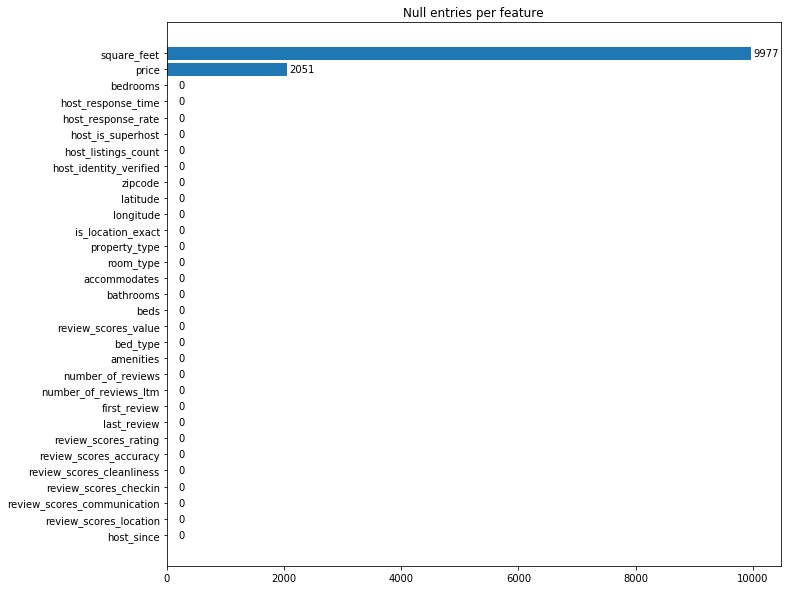

In [6]:
# Check for valid data points

data_with_null = data_input.isnull().sum(axis=0).reset_index()
data_with_null.columns = ['feature', 'count']
data_with_null = data_with_null.sort_values(by='count')

fig, ax = plt.subplots(figsize=(11,10))
rects = ax.barh(np.arange(data_with_null.shape[0]), data_with_null['count'].values)
ax.set_yticks(np.arange(data_with_null.shape[0]))
ax.set_yticklabels(data_with_null['feature'].values, rotation='horizontal')
ax.set_title("Null entries per feature")
for i in range(data_with_null.shape[0]):
    count = data_with_null['count'].values[i]
    ax.text(count + 250, i, '%d' % int(count), ha='center', va='center')
plt.show()

# Analysis

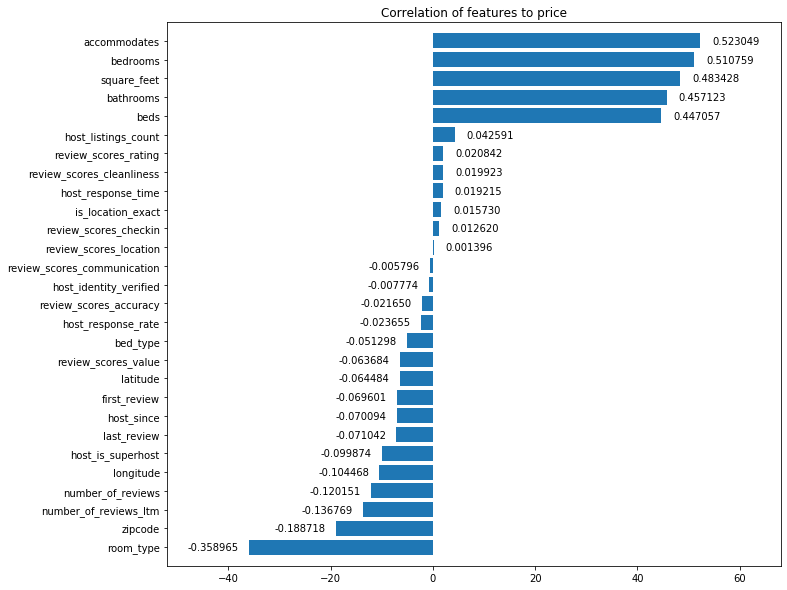

In [7]:
# Correlation of each feature to price

corr = data_input.corr()['price'].reset_index()
corr = corr.drop(len(corr) - 1)
corr.columns = ['feature', 'corr']
corr = corr.sort_values(by='corr')

fig, ax = plt.subplots(figsize=(11,10))
rects = ax.barh(np.arange(corr.shape[0]), corr['corr'].values * 100)
ax.set_yticks(np.arange(corr.shape[0]))
plt.xlim(-52,68)
plt.ylim(-1,28)
ax.set_yticklabels(corr['feature'].values, rotation='horizontal')
ax.set_title("Correlation of features to price")
for i in range(corr.shape[0]):
    ax.text(corr['corr'].values[i] * 100 + np.sign(corr['corr'].values[i]) * 7, i, '%f' % corr['corr'].values[i], ha='center', va='center')
plt.show()

# More Analysis

First, we look at the correlation of amenities to price.

In [8]:
# Build one-hot vectors of non-numeric features, then find correlations to prices

# Amenities
amenities_set = dict()
result_set = set()
for index in data_input.index.values:
    curr_string = data_input.loc[index,"amenities"]
    if len(curr_string) < 3:
        amenities_set[index] = set()
        continue
    curr_list = map(str.strip, curr_string[1:-1].replace("\"","").replace("\'","").split(","))
    curr_set = set(curr_list)
    amenities_set[index] = curr_set
    result_set |= curr_set
unique_amenities = sorted(result_set)

amenities_dict = dict()
for amenity in unique_amenities:
    amenities_dict[amenity] = dict()
amenities_dict["price"] = dict()

for index in data_input.index.values:
    amenities_dict["price"][index] = data_input.loc[index, "price"]
    for amenity in unique_amenities:
        if amenity in amenities_set[index]:
            amenities_dict[amenity][index] = True
        else:
            amenities_dict[amenity][index] = False

amenities = pd.DataFrame(amenities_dict)

In [9]:
# Calculate biserial correlation

from scipy.stats import pointbiserialr

amenities = amenities.dropna()
corr = dict()
corr['corr'] = dict()
for amenity in result_set:
    corr['corr'][amenity] = pointbiserialr(amenities[amenity].values, amenities['price'].values)[0]
corr = pd.DataFrame(corr)

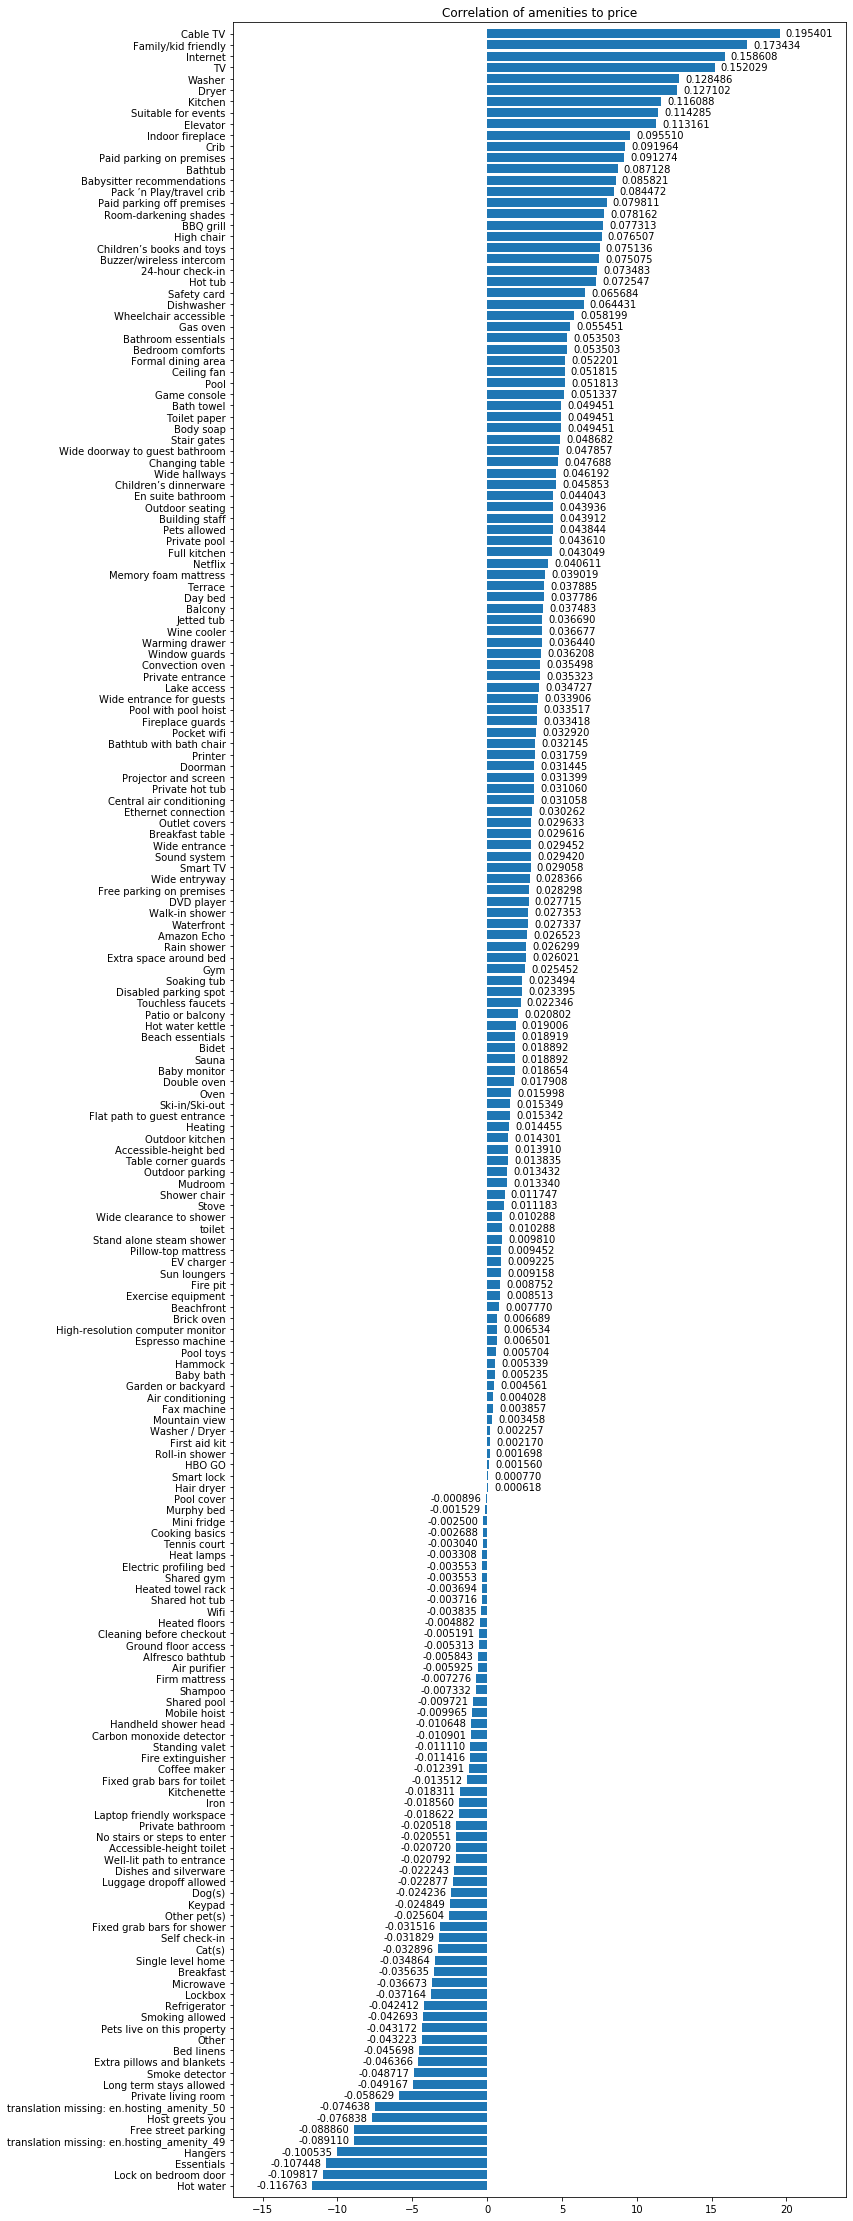

In [10]:
# Correlation between amenities and price

corr = corr.sort_values(by='corr')

fig, ax = plt.subplots(figsize=(11,40))
rects = ax.barh(np.arange(corr.shape[0]), corr['corr'].values * 100)
ax.set_yticks(np.arange(corr.shape[0]))
plt.xlim(-17,24)
plt.ylim(-1,192)
ax.set_yticklabels(corr['corr'].keys(), rotation='horizontal')
ax.set_title("Correlation of amenities to price")
for i in range(corr.shape[0]):
    ax.text(corr['corr'].values[i] * 100 + np.sign(corr['corr'].values[i]) * 2, i, '%f' % corr['corr'].values[i], ha='center', va='center')
plt.show()

Finally, we look at the correlation of property type to price.

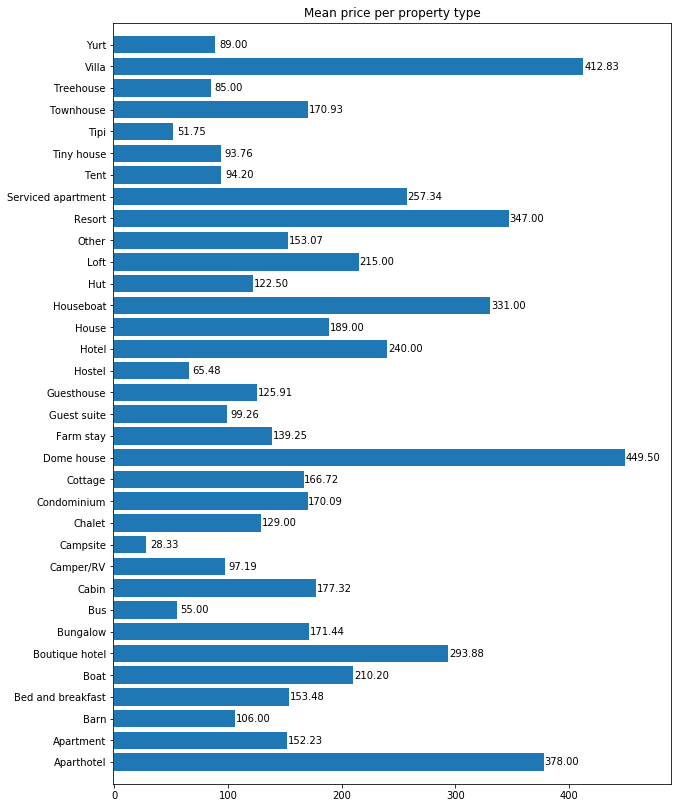

In [214]:
# Get mean price per property type

unique_properties = ['House', 'Guesthouse', 'Guest suite', 'Condominium', 'Apartment', 'Townhouse', 'Bungalow', 'Loft', 'Other', 'Cabin', 'Villa', 'Cottage', 'Bed and breakfast', 'Campsite', 'Tent', 'Camper/RV', 'Tiny house', 'Farm stay', 'Serviced apartment', 'Boutique hotel', 'Dome house', 'Bus', 'Tipi', 'Treehouse', 'Barn', 'Boat', 'Hostel', 'Aparthotel', 'Yurt', 'Houseboat', 'Resort', 'Hotel', 'Chalet', 'Hut']

property_dict = OrderedDict()
for prop in unique_properties:
    property_dict[prop] = (0,0)
    
for index in data_input.index.values:
    current_prop = data_input.loc[index, "property_type"]
    price = data_input.loc[index, "price"]
    if np.isnan(price):
        continue
    price_sum,count = property_dict[current_prop]
    price_sum += price
    count += 1
    property_dict[current_prop] = (price_sum,count)

mean_prices = {name: total/count for (name,(total,count)) in property_dict.items()}
x,y = zip(*sorted(mean_prices.items()))
# lists = sorted(d.items()) # sorted by key, return a list of tuples
# x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax = plt.subplots(figsize=(10,14))
ax.set_title("Mean price per property type")
ax.barh(x, y)
plt.xlim(-1,490)
plt.ylim(-1,34)
for i in range(len(x)):
    ax.text(y[i] + 16, i, '%.2f' % y[i], ha='center', va='center')
plt.show()

In [0]:
# Build one-hot vectors of non-numeric features, then find correlations to prices

# Properties
unique_properties = ['House', 'Guesthouse', 'Guest suite', 'Condominium', 'Apartment', 'Townhouse', 'Bungalow', 'Loft', 'Other', 'Cabin', 'Villa', 'Cottage', 'Bed and breakfast', 'Campsite', 'Tent', 'Camper/RV', 'Tiny house', 'Farm stay', 'Serviced apartment', 'Boutique hotel', 'Dome house', 'Bus', 'Tipi', 'Treehouse', 'Barn', 'Boat', 'Hostel', 'Aparthotel', 'Yurt', 'Houseboat', 'Resort', 'Hotel', 'Chalet', 'Hut']

property_dict = dict()
for prop in unique_properties:
    property_dict[prop] = dict()
property_dict["price"] = dict()

for index in data_input.index.values:
    property_dict["price"][index] = data_input.loc[index, "price"]
    current_prop = data_input.loc[index, "property_type"]
    for prop in unique_properties:
        if prop == current_prop:
            property_dict[prop][index] = 1
        else:
            property_dict[prop][index] = 0

properties = pd.DataFrame(property_dict)

In [0]:
# Calculate biserial correlation

properties = properties.dropna()
corr = dict()
corr['corr'] = dict()
for prop in unique_properties:
    corr['corr'][prop] = pointbiserialr(properties[prop].values, properties['price'].values)[0]
corr = pd.DataFrame(corr)

assert(np.all(properties.loc[:,properties.columns!="price"].sum(axis=1).values == 1))
assert(np.all(properties.loc[:,properties.columns!="price"].sum(axis=0).values > 0))

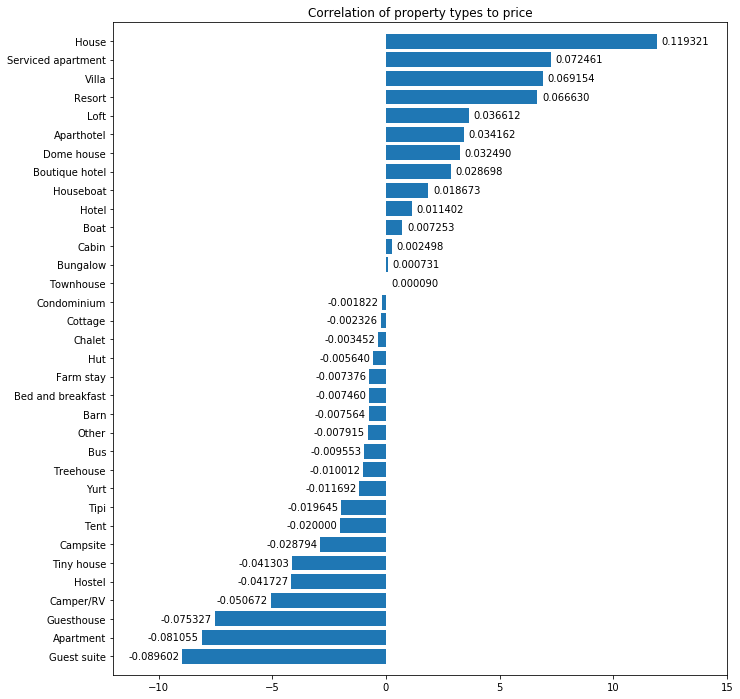

In [217]:
# Correlation between property type and price 

corr = corr.sort_values(by='corr')

fig, ax = plt.subplots(figsize=(11,12))
rects = ax.barh(np.arange(corr.shape[0]), corr['corr'].values * 100)
ax.set_yticks(np.arange(corr.shape[0]))
plt.xlim(-12,15)
plt.ylim(-1,34)
ax.set_yticklabels(corr['corr'].keys(), rotation='horizontal')
ax.set_title("Correlation of property types to price")
for i in range(corr.shape[0]):
    ax.text(corr['corr'].values[i] * 100 + np.sign(corr['corr'].values[i]) * 1.25, i, '%f' % corr['corr'].values[i], ha='center', va='center')
plt.show()

# Feature Selection

Start by separating the data.

In [13]:
# Separate and validate data

train = data_input[data_input.index.isin(train_input["id"])]
train_length = train.shape[0]
assert(train_length == train_input.shape[0])
val = data_input[data_input.index.isin(val_input["id"])]
val_length = val.shape[0]
assert(val_length == val_input.shape[0])
test = data_input[data_input.index.isin(test_input["id"])]
test_length = test.shape[0]
assert(test_length == test_input.shape[0])

assert(train[train.price.isnull()].shape[0] == 0)
assert(val[val.price.isnull()].shape[0] == 0)

print("Training set has", train_length, "entries")
print("Validation set has", val_length, "entries")
print("Test set has", test_length, "entries")

Training set has 6152 entries
Validation set has 1949 entries
Test set has 2051 entries


In [14]:
# Choose features we want to use

features_wanted = ["host_since", "host_is_superhost", "host_listings_count", "host_identity_verified", "zipcode", "latitude", "longitude", "is_location_exact", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "bed_type", "number_of_reviews", "number_of_reviews_ltm", "first_review", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]
amenities_wanted = ["Cable TV" , "Family/kid friendly", "Internet", "TV", "Washer", "Dryer", "Kitchen", "Suitable for events", "Elevator", "Indoor fireplace", "Crib", "Hangers", "Essentials", "Lock on bedroom door", "Hot water"]
property_types_wanted = ["House", "Guesthouse", "Apartment", "Guest suite"]

Build our training set

In [15]:
# Build final train dataframe

train_final = train[features_wanted + ["price"]]

amenities_dict = dict()
property_types_dict = dict()

for amenity in amenities_wanted:
    amenities_dict[amenity] = dict()

for property_type in property_types_wanted:
    property_types_dict[property_type] = dict()
    
for index in train_final.index.values:
    amenities = data_input["amenities"][index]
    property_type = data_input["property_type"][index]
    for current_property_type in property_types_wanted:
        if property_type == current_property_type:
            property_types_dict[current_property_type][index] = 1
        else:
            property_types_dict[current_property_type][index] = 0
    for current_amenity in amenities_wanted:
        if current_amenity in amenities:
            amenities_dict[current_amenity][index] = 1
        else:
            amenities_dict[current_amenity][index] = 0

amenities_final = pd.DataFrame(amenities_dict)
property_types_final = pd.DataFrame(property_types_dict)

train_final = pd.concat([train_final, amenities_final, property_types_final], axis=1)

train_final_length = train_final.shape[0]

In [16]:
train_final_with_null = train_final.isnull().sum(axis=0).reset_index()
train_final_with_null.columns = ['feature', 'count']
train_final_with_null = train_final_with_null.loc[train_final_with_null['count'] > 0]
assert(train_final_with_null.shape[0] == 0)

Build our validation data

In [17]:
# Build final validation dataframe

val_final = val[features_wanted + ["price"]]

amenities_dict = dict()
property_types_dict = dict()

for amenity in amenities_wanted:
    amenities_dict[amenity] = dict()

for property_type in property_types_wanted:
    property_types_dict[property_type] = dict()
    
for index in val_final.index.values:
    amenities = data_input["amenities"][index]
    property_type = data_input["property_type"][index]
    for current_property_type in property_types_wanted:
        if property_type == current_property_type:
            property_types_dict[current_property_type][index] = 1
        else:
            property_types_dict[current_property_type][index] = 0
    for current_amenity in amenities_wanted:
        if current_amenity in amenities:
            amenities_dict[current_amenity][index] = 1
        else:
            amenities_dict[current_amenity][index] = 0

amenities_final = pd.DataFrame(amenities_dict)
property_types_final = pd.DataFrame(property_types_dict)

val_final = pd.concat([val_final, amenities_final, property_types_final], axis=1)

val_final_length = val_final.shape[0]

In [18]:
# Fix missing features in validation set

val_final_with_null = val_final.isnull().sum(axis=0).reset_index()
val_final_with_null.columns = ['feature', 'count']
val_final_with_null = val_final_with_null.loc[val_final_with_null['count'] > 0]
assert(val_final_with_null.shape[0] == 0)

Build our test data

In [19]:
# Build final test dataframe

test_final = test[features_wanted]

amenities_dict = dict()
property_types_dict = dict()

for amenity in amenities_wanted:
    amenities_dict[amenity] = dict()

for property_type in property_types_wanted:
    property_types_dict[property_type] = dict()
    
for index in test_final.index.values:
    amenities = data_input["amenities"][index]
    property_type = data_input["property_type"][index]
    for current_property_type in property_types_wanted:
        if property_type == current_property_type:
            property_types_dict[current_property_type][index] = 1
        else:
            property_types_dict[current_property_type][index] = 0
    for current_amenity in amenities_wanted:
        if current_amenity in amenities:
            amenities_dict[current_amenity][index] = 1
        else:
            amenities_dict[current_amenity][index] = 0

amenities_final = pd.DataFrame(amenities_dict)
property_types_final = pd.DataFrame(property_types_dict)

test_final = pd.concat([test_final, amenities_final, property_types_final], axis=1)

test_final_length = test_final.shape[0]

In [20]:
# Fix missing features in test set

test_final_with_null = test_final.isnull().sum(axis=0).reset_index()
test_final_with_null.columns = ['feature', 'count']
test_final_with_null = test_final_with_null.loc[test_final_with_null['count'] > 0]
assert(test_final_with_null.shape[0] == 0)

In [21]:
# Convert to numpy arrays

X_train = train_final.loc[:, train_final.columns != "price"].to_numpy()
y_train = train_final.loc[:, train_final.columns == "price"].to_numpy()
X_val = val_final.loc[:, val_final.columns != "price"].to_numpy()
y_val = val_final.loc[:, val_final.columns == "price"].to_numpy()
X_test = test_final.to_numpy()

# Learning

Try linear regression

In [22]:
# Linear regression

def add_column(X):
    return np.insert(X, 0, np.ones(X.shape[0]), axis=1)

def predict(X, theta):
    return np.dot(theta.T, add_column(X).T)

def loss(X, y, theta):
    return np.sqrt(np.mean(np.square(predict(X,theta).T - y)))

def loss_gradient(X, y, theta):
    errors = predict(X, theta).T - y
    loss_grad = np.dot(add_column(X).T, errors) / X.shape[0]
    return loss_grad

def run_gd(loss, loss_gradient, X_train, y_train, X_val, y_val, theta_init, lr=0.01, n_iter=1500):
    theta_current = theta_init.copy()
    loss_values = []
    theta_values = []
    val_loss_values = []
    
    for i in range(n_iter):
        loss_value = loss(X_train, y_train, theta_current)
        loss_values.append(loss_value)
        theta_values.append(theta_current)
        val_loss_values.append(loss(X_val, y_val, theta_current))
        
        gradient = lr * loss_gradient(X_train, y_train, theta_current)
        theta_current = np.subtract(theta_current, gradient)
        
    return theta_current, loss_values, val_loss_values, theta_values

In [23]:
# Initialise theta

theta = np.random.rand(X_train.shape[1] + 1, 1)

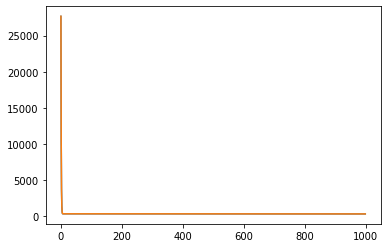

In [24]:
# Run gradient descent

theta, loss_values, val_loss_values, theta_values = run_gd(loss, loss_gradient, X_train, y_train, X_val, y_val, theta, n_iter=1000, lr=1e-10)
plt.plot(loss_values)
plt.plot(val_loss_values)
plt.show()

In [25]:
# Use closed form

X_train_with_ones = add_column(X_train)
theta_max = np.linalg.inv(X_train_with_ones.T @ X_train_with_ones) @ X_train_with_ones.T @ y_train
print("Training error is", loss(X_train, y_train, theta_max))
print("Cross validation error is", loss(X_val, y_val, theta_max))

Training error is 100.30300333359077
Cross validation error is 97.59659759351385


In [26]:
# Do predictions

y_test = predict(X_test, theta_max).T
test["price"] = y_test

/Users/danielvaroli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Submission

In [0]:
from IPython.display import FileLink

In [235]:
test.to_csv("predictions.csv",header=True, columns=["price"])
FileLink(r'predictions.csv')

/content/predictions.csv